In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Функции

In [2]:
def data_load():
    df = pd.read_excel('/Users/nkt1lyn/coef_opr_actions.xlsx')
    return df


In [3]:
def data_shape(df, date1, date2):
    df = df.loc[(df['Time'] >= date1) & (df['Time'] <= date2)]
    return df


In [4]:
def diff_diagram(level_df, xlabel, title):
    plt.figure(figsize=(10, 7))

    bar1 = plt.bar(np.arange(len(level_df['Период'])), level_df['Отклонение от BL White'], color='white', edgecolor = "black", alpha=0.7, label='Белые дни')
    bar2 = plt.bar(np.arange(len(level_df['Период'])), level_df['Отклонение от BL Black'], color='black', edgecolor = "black", alpha=0.7, label='Черные дни')

    for i, (val1, val2) in enumerate(zip(level_df['Отклонение от BL White'], level_df['Отклонение от BL Black'])):
        plt.text(i, val1, f"{val1:.2f}%", ha='center', va='bottom' if val1 >= 0 else 'top', fontsize=9, color='black')
        plt.text(i, val2, f"{val2:.2f}%", ha='center', va='bottom' if val2 >= 0 else 'top', fontsize=9, color='black')

    plt.axhline(y=0, color='black')
    plt.xlabel(xlabel)
    plt.ylabel('Отклонение от базового уровня, %')
    plt.title(title)
    plt.xticks(np.arange(len(level_df['Период'])), level_df['Период'])
    plt.legend(loc='lower left')
    plt.show()


In [5]:
def day_cat(df):
    df['Категория дня'] = np.where((df['Var1'] >= mean - std) & (df['Var1'] <= mean + std), 'White', 'Black').astype(str)
    return df


In [6]:
def BW_level(df, period, BaseLevel):
    period_list = []

    for p in period:
        count_white_days = np.sum((df.loc[df['Период'] == p, 'Категория дня'] == 'White'))
        count_black_days = np.sum((df.loc[df['Период'] == p, 'Категория дня'] == 'Black'))    
        p_len = count_white_days + count_black_days

        percentage_white_days = (count_white_days / p_len) * 100
        percentage_black_days = (count_black_days / p_len) * 100

        diff_1 = percentage_white_days - BaseLevel[0]
        diff_2 = percentage_black_days - BaseLevel[1]

        period_list.append({
            'Период': p,
            'Уровень белых дней': percentage_white_days,
            'Уровень черных дней': percentage_black_days,
            'Отклонение от BL White': diff_1,
            'Отклонение от BL Black': diff_2
        })

    return pd.DataFrame(period_list)


In [7]:
def shift_model(df, l):
    l = -l
    df['Период'] = np.roll(df['Период'], l)
    # df = pd.concat([df.iloc[l:], df.iloc[:l]], ignore_index=True)
    if l > 0:
        df.loc[:l-1, 'Период'] = 1
    elif l == 0:
      return df
    else:
      df.iloc[l:, df.columns.get_loc('Период')] = 13
    return df

In [8]:
def model_with_shift(l):
    df = data_load()
    df = data_shape(df, '2019-12-21', '2023-03-04')
    df = day_cat(df)
    df['Период'] = (df['Time'].sub(df['Time'].min()) // pd.Timedelta('90 days')).add(1)
    df = shift_model(df, l)
    return df


In [9]:
def calculate_levels(group):
   Std1 = (group['Var1'] >= mean - std) & (group['Var1'] <= mean + std)

   W = Std1.sum()
   B = len(group) - W

   BL1 = 100 * W / len(group)
   BL2 = 100 * B / len(group)

   return pd.Series({'Период': group['Период'].iloc[0], 'BW': [BL1, BL2]})

In [10]:
def BW_calc(df):
    result = df.groupby('Период').apply(calculate_levels).reset_index(drop=True)
    W = result['BW'].apply(lambda x: x[0]).sum()/len(result)
    B = result['BW'].apply(lambda x: x[1]).sum()/len(result)
    return [W, B]

In [11]:
def FE_table(list):
    model = []
    fit_error = []
    
    for l in list:
        model.append('i = ' + str(l))
        fit_error.append(fit_error_calc(BW_calc(model_with_shift(l))).round(4))

    FE = pd.DataFrame({
        'Model': model,
        'Fit-error': fit_error
        })
    return FE

In [12]:
def plot_shift(df, l):
    result_df = df.groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bar_width = 0.4
    bar_positions1 = result_df['Период'].values
    bar_positions2 = bar_positions1 + bar_width

    fig, ax = plt.subplots(figsize=(16, 6))
    bar1 = ax.bar(bar_positions1, [val[0] for val in result_df['BW']], width=bar_width, color='white', edgecolor='black', label='Белые дни')
    bar2 = ax.bar(bar_positions2, [val[1] for val in result_df['BW']], width=bar_width, color='black', edgecolor='black', label='Черные дни')

    for i, (bw_values, period) in enumerate(zip(result_df['BW'], result_df['Период'])):
        ax.text(bar_positions1[i], bw_values[0] + 1, f'{bw_values[0]:.2f}', ha='center', va='bottom', fontsize=7)
        ax.text(bar_positions2[i], bw_values[1] + 1, f'{bw_values[1]:.2f}', ha='center', va='bottom', fontsize=7)

    ax.set_xticks(bar_positions1 + bar_width / 2)
    ax.set_xticklabels(result_df['Период'])
    ax.legend()

    # Добавление подписей осей и заголовка
    ax.set_xlabel('Паттерн модели с параметром сдвига l = ' + str(l))
    ax.set_ylabel('Уровени белого и черного в (%)')

    plt.show()


### 1. Моделирование типичного свойства данных

#### 1.1 Равномерное агрегирование по времени

Задача А: для равномерно агрегированной модели из 13-ти столбиков по 90 дней каждый определить
уровень белого и черного BW всей модели на всем наборе данных.


In [13]:
df = data_load()
df = data_shape(df, '2019-12-21', '2023-03-04')

In [14]:
df['Период'] = (df['Time'].sub(df['Time'].min()) // pd.Timedelta('90 days')).add(1)

In [15]:
mean = df['Var1'].mean()
std = df['Var1'].std()
Std1 = (df['Var1'] >= mean - std) & (df['Var1'] <= mean + std)

W = Std1.sum()
B = len(df) - W

BL1 = 100 * W / len(df)
BL2 = 100 * B / len(df)

BL = [BL1, BL2]
BL


[71.02564102564102, 28.974358974358974]

In [16]:
def fit_error_calc(BW, BL = BL):
    fit_error = np.linalg.norm([BW[0]-BL[0], BW[1]-BL[1]])
    return fit_error

In [17]:
df

,Time,Var1,Период
0,2019-12-21,0.543378,1
1,2019-12-22,0.504853,1
2,2019-12-23,0.430356,1
3,2019-12-24,0.527782,1
4,2019-12-25,0.497517,1
...,...,...,...
1165,2023-02-28,0.479268,13
1166,2023-03-01,0.456620,13
1167,2023-03-02,0.550202,13
1168,2023-03-03,0.472124,13


In [18]:
result = df.groupby('Период').apply(calculate_levels).reset_index(drop=True)
result

,Период,BW
0,1,"[64.44444444444444, 35.55555555555556]"
1,2,"[48.888888888888886, 51.111111111111114]"
2,3,"[74.44444444444444, 25.555555555555557]"
3,4,"[67.77777777777777, 32.22222222222222]"
4,5,"[84.44444444444444, 15.555555555555555]"
5,6,"[78.88888888888889, 21.11111111111111]"
6,7,"[83.33333333333333, 16.666666666666668]"
7,8,"[63.333333333333336, 36.666666666666664]"
8,9,"[68.88888888888889, 31.11111111111111]"
9,10,"[73.33333333333333, 26.666666666666668]"


In [19]:
W = result['BW'].apply(lambda x: x[0]).sum()/len(result)
B = result['BW'].apply(lambda x: x[1]).sum()/len(result)

BW = [W, B]
BW


[71.02564102564102, 28.97435897435897]

#### 1.2 Оценка соответствия модели данным


Задача Б: для равномерно агрегированной модели из 13-ти столбиков по 90 дней каждый вычислить ошибку соответсвия этой модели данным.


In [20]:
fit_error = np.linalg.norm([BW[0]-BL[0], BW[1]-BL[1]])
fit_error

3.552713678800501e-15

если я правильно понимаю, то так как модель в состоянии l=0, то она полностью соответсвует данным, поэтому получаем число, очень близкое к 0, а при сдвиге модели fit_error будет увеличиваться.

#### 1.3 Параметризация равномерно агрегированной модели


In [21]:
df = data_load()
df = data_shape(df, '2019-12-21', '2023-03-04')
df['Период'] = (df['Time'].sub(df['Time'].min()) // pd.Timedelta('90 days')).add(1)

In [22]:
df = shift_model(df, 1)
df['Период'].value_counts()


Период
13    91
2     90
3     90
4     90
5     90
6     90
7     90
8     90
9     90
10    90
11    90
12    90
1     89
Name: count, dtype: int64

In [23]:
df = shift_model(df, -2)
df['Период'].value_counts()


Период
1     91
2     90
3     90
4     90
5     90
6     90
7     90
8     90
9     90
10    90
11    90
12    90
13    89
Name: count, dtype: int64

#### 1.4 Сдвиг равномерно-агрегированной модели по параметру l


Задача В: для моделей с параметрами l = 1 и l = -1 определить уровени белого и черного BW для каждой модели на всем наборе данных; вычислить ошибку соответсвия модели данным при l = 1 и при l = -1; вычислить ошибку соответсвия модели данным при l = 0 и сравнить с ответом Задачи Б.


In [24]:
df0 = model_with_shift(0)
BW = BW_calc(df0)
BW

[71.02564102564102, 28.97435897435897]

In [25]:
fit_error = fit_error_calc(BW)
fit_error

3.552713678800501e-15

In [26]:
df1 = model_with_shift(1)
BW = BW_calc(df1)
BW

[71.02120869623029, 28.978791303769697]

In [27]:
fit_error = fit_error_calc(BW)
fit_error

0.006268260365556086

In [28]:
df_1 = model_with_shift(-1)
BW = BW_calc(df_1)
BW

[71.0297673132591, 28.970232686740893]

In [29]:
fit_error = fit_error_calc(BW)
fit_error

0.005835451911740728

1.5 Сравнение моделей между собой в метрике R-квадрат

In [30]:
models = {}
for l in range(-1, 2):
    models[l] = model_with_shift(l)

In [31]:
FE = FE_table([l for l in range(-1, 2)])

In [32]:
from sklearn.metrics import r2_score


In [33]:
result = models[0].groupby('Период').apply(calculate_levels).reset_index(drop=True)
bw_list = result['BW'].tolist()
ytrue = [sublist[0] for sublist in bw_list]
ytrue

[64.44444444444444,
 48.888888888888886,
 74.44444444444444,
 67.77777777777777,
 84.44444444444444,
 78.88888888888889,
 83.33333333333333,
 63.333333333333336,
 68.88888888888889,
 73.33333333333333,
 78.88888888888889,
 66.66666666666667,
 70.0]

In [41]:
r2_values = []
for l in range(-1, 2):
    result = models[l].groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bw_list = result['BW'].tolist()
    ypred = [sublist[0] for sublist in bw_list]
    r2_values.append(1-r2_score(ytrue, ypred))

FE['1 - R^2'] = r2_values

In [42]:
FE.drop(1, axis=0).drop('Fit-error', axis=1)

,Model,1 - R^2
0,i = -1,0.002487
2,i = 1,0.008540


### 2.2 Визуализация результатов
#### 2.1 Создание таблицы со значениями ошибки соответствия данным


In [43]:
FE


,Model,Fit-error,1 - R^2
0,i = -1,0.0058,0.002487
1,i = 0,0.0000,0.000000
2,i = 1,0.0063,0.008540


#### 2.2 Построение диаграмм


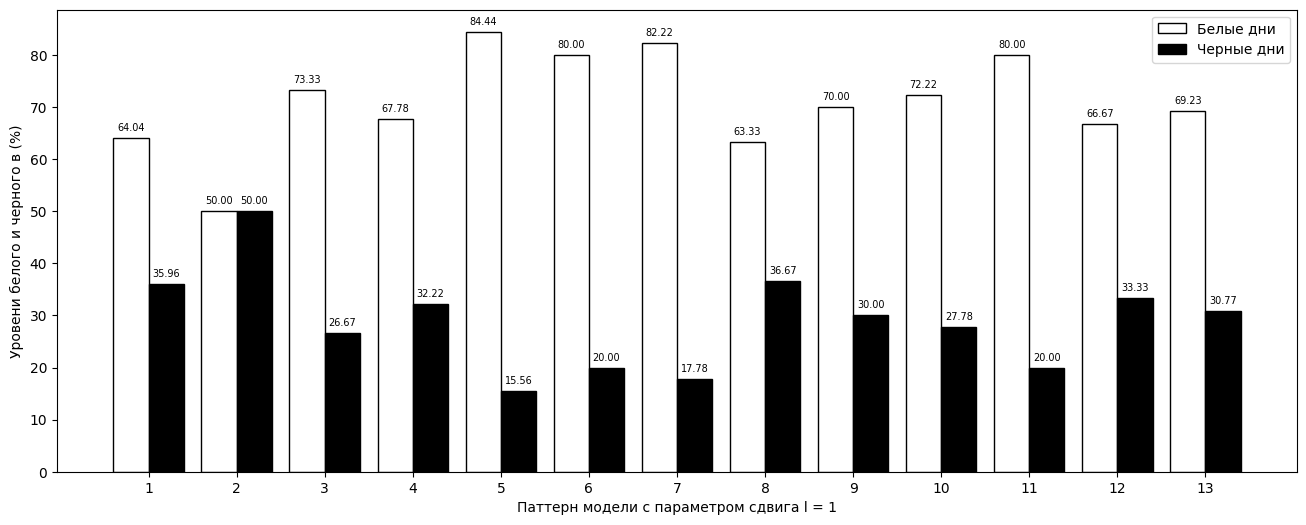

In [37]:
plot_shift(df1, 1)


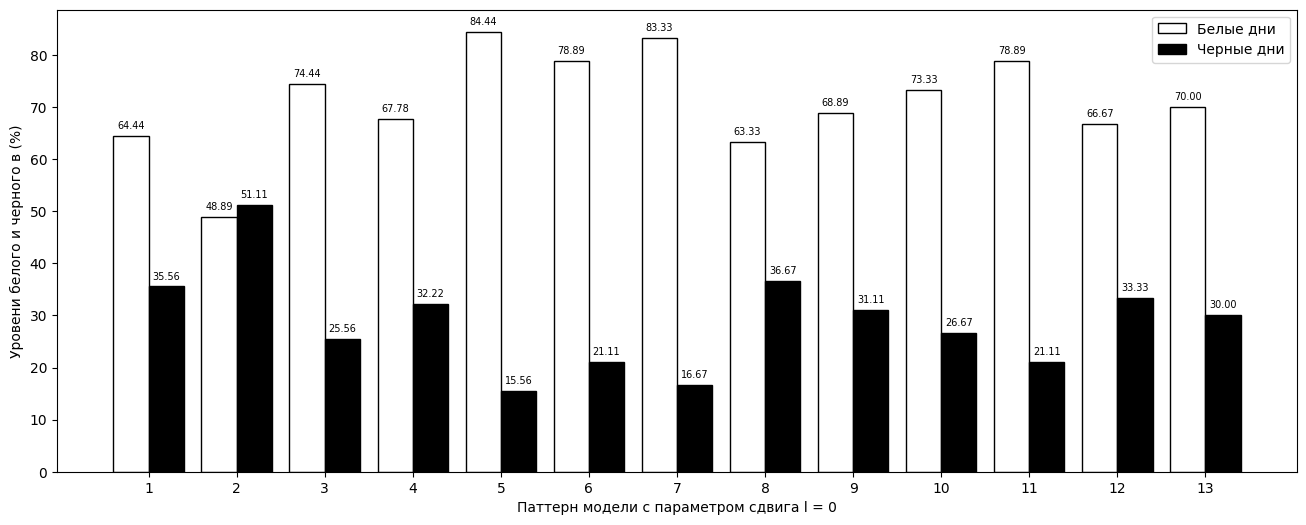

In [38]:
plot_shift(df0, 0)

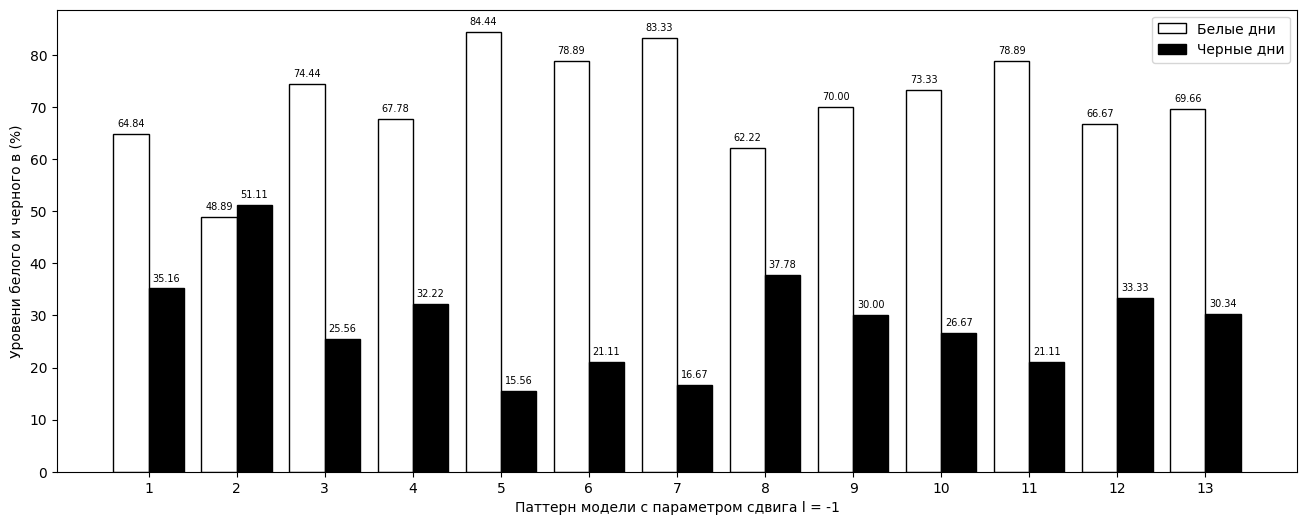

In [39]:
plot_shift(df_1, -1)